<br>[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)<br>

# Accessing and visualizing data from PECD4.2 NetCDF file: an example for gridded 2 metre air temperature

This notebook demonstrates how to work with the Pan-European Climate Database version 4.2 ([PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) NetCDF dataset, specifically focusing on historical (ERA5) 2-metre air temperature data for the year 2024. It guides you through metadata exploration and the creation of four basic visualizations:

1. A map showing the mean temperature at each grid point over the time period considered (year 2024).
2. A line plot with a time series of hourly temperature values at the nearest grid point to a user-specified location.
3. An empirical cumulative distribution (ECDF) plot, along with the extraction of some relevant quantiles, for the hourly temperature values at the selected grid point.
4. A line plot with a time series of daily and monthly mean temperature values at the same grid point of 2.

In the following sections, you will:

- Download and open the 2024 temperature NetCDF file.
- Compute a mean across the time dimension and plot it on a map.
- Select a location, extract data from the nearest grid point and visualize its hourly temperature evolution.
- Compute the temperature ECDF, visualize it and exctract some quantiles.
- For the same grid point, visualize its daily and monthly mean temperature time evolution in the same plot.

All these operations will be performed using Python.

> **Note**  
>[ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) is the fifth-generation atmospheric reanalysis program developed by the European Centre for Medium-Range Weather Forecasts (ECMWF) in collaboration with the Copernicus Climate Change Service (C3S). It operates on a global scale and has a spatial resolution of $0.25° \times \ 0.25°$ (latitude and longitude), which corresponds to approximately 31 km; estimates of atmospheric
variables are provided hourly throughout a temporal coverage of about eight decades, from 1940 to today.

## Learning objectives 🧠

In this notebook you will learn how to work with climate data in NetCDF format using Python. You will explore the structure and metadata of a gridded file from the historical stream (with similar considerations for the projection stream), compute temporal aggregates of 2-metre air temperature, and create meaningful visualizations to represent these results. Specifically, you will extract and plot the mean temperature values over a given period and generate time series (hourly, daily and monthly temperature evolution) for a specific location of your choice.

By the end of this notebook, you will have a practical understanding of how to handle gridded climate data with Python tools such as xarray, pandas and matplotlib, and you will be able to adapt these techniques to similar datasets and applications.

The code structure is kept as simple as possible, so you can easily reuse and adapt for visualizing other files, variables, or periods.

## Target Audience 🎯

**Anyone** interested in learning how to work with PECD4.2 climate data in NetCDF format, including data exploration and basic visualization techniques.

## Prepare your environment

### Import required packages

We begin by importing the required packages: these include [numpy](https://numpy.org/doc/stable/) and [xarray](https://docs.xarray.dev/en/stable/), which are used for handling multidimensional arrays of data. [Pandas](https://pandas.pydata.org/) is a widely used library for data manipulation and analysis, here useful to work with time coordinates format. The [os](https://docs.python.org/3/library/os.html) module provides a way to interact with the operating system and it is used here to manipulate paths; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) is a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing you to download the relevant data for this work. [matplotlib](https://matplotlib.org/) is a library for creating static, animated and interactive visualizations in Python. [cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a Python package designed for geospatial data processing that allows to produce maps and other geospatial data analyses.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import cdsapi

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes, like ```"your_api_key"```). Your token can be found on the CDS portal at: https://cds.climate.copernicus.eu/profile (you will need to log in to view your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

The data can be downloaded from the PECD CDS download form, by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be copied and pasted directly into a cell of your Jupyter Notebook. This step has already been done for you in the cell below, but if you'd like to try it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example, we use data from the PECD version "PECD4.2" for the "Historical" temporal stream (based on "ERA5 reanalysis" data). The selected variable is the "2m temperature", taken for the year 2024 and with spatial resolution of 0.25°.

The API request reflecting these selections is shown in the next cell.

In [7]:
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "year": ["2024"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["0_25_degree"],
}

Before running the download we can make sure there is a dedicated folder ready to host the data.

In [2]:
input_dir = "cds_data/explore_netcdf_data/"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [ ]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/data.zip")

Since our data are inside zipped files we need to unzip them. The final NetCDF file will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the PECD.

In [15]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {input_dir}/{fname} -d {input_dir}")

Archive:  cds_data/explore_netcdf_data//data.zip
  inflating: cds_data/explore_netcdf_data/H_ERA5_ECMW_T639_TA-_0002m_Pecd_025d_S202401010000_E202412312300_INS_MAP_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.nc  


## Open the NetCDF (.nc) file, check temporal-spatial domain and temperature units

### Open and inspect file

Using ```os.system(f"mkdir -p {save_path}")``` we can create a folder called "explore_netcdf_data", in which the .png files containing the final plots will be saved. We initialize the variables ```file_dir```, to which the directory path of the NetCDF file is assigned, and ```filename```, which stores the name of the NetCDF file itself. The function ```os.path.join()``` combines the directory and filename to create the full path of the file: this is used to eventually open the file by writing ```ds = xr.open_dataset(file_path)```. This last function from the xarray library reads the data and metadata from the file and loads it into an xarray [Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) object, which is assigned to the variable ```ds```. The ```chunks={"time": 744}``` argument tells xarray to load the data in chunks along the "time" dimension, with each chunk containing 744 time steps, so that they contain temperature data for each month: this can improve both performance and memory usage. After that we inspect some general information contained in the Dataset by calling ```print(ds)```.






In [3]:
# create folder to store plots
save_path = "results/explore_netcdf_data"
os.system(f"mkdir -p {save_path}")

file_dir = "cds_data/explore_netcdf_data"
filename = (
    "H_ERA5_ECMW_T639_TA-_0002m_Pecd_025d_"
    "S202401010000_E202412312300_INS_MAP_01h_COM_noc_org_"
    "NA_NA---_NA---_NA---_PECD4.2_fv1.nc"
)
file_path = os.path.join(file_dir, filename)

ds = xr.open_dataset(file_path, chunks={"time": 744})
print(ds)

<xarray.Dataset> Size: 5GB
Dimensions:    (time: 8784, latitude: 229, longitude: 305)
Coordinates:
  * latitude   (latitude) float32 916B 75.0 74.75 74.5 74.25 ... 18.5 18.25 18.0
  * time       (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
  * longitude  (longitude) float32 1kB -31.0 -30.75 -30.5 ... 44.5 44.75 45.0
Data variables:
    t2m        (time, latitude, longitude) float64 5GB dask.array<chunksize=(744, 229, 305), meta=np.ndarray>
Attributes:
    title:        2 metre temperature; data for ENTSO-E PECD Version 4.2; fil...
    institution:  Copernicus Climate Change Service, Sectoral Information Sys...
    history:      2025-02-19 08:50:22 GMT by write_hist_xr_to_nc-0.1.dev51+g1...
    references:   
    Conventions:  CF-1.12-draft
    source:       ERA5 reanalysis data provided by ECMWF (https://www.ecmwf.i...


We see that the Dataset contains one variable called ```t2m```, which indeed represents the 2-metre air temperature. The spatial and temporal location of the grid points are given by ```latitude```, ```longitude``` and ```time``` coordinates: let's now find out what the temporal and spatial domains of our file are.

### Temporal domain

In [4]:
first_t = pd.to_datetime(ds.time.min().item())
last_t = pd.to_datetime(ds.time.max().item())
print(f"Temporal domain: from {first_t} to {last_t}")

Temporal domain: from 2024-01-01 00:00:00 to 2024-12-31 23:00:00


This gives us the temporal range of the ```t2m``` values stored in our input file. Through ```ds.time``` we are able to access the time coordinate; ```.max()``` and ```.min()``` find out the maximum and minimum values within this coordinate, while ```.item()``` extracts the associated scalar value. Everything is made more readable by calling the ```pd.to_datetime()``` function, which converts the extracted time value into a pandas datetime object.

As expected, we see that our time coordinates covers the entire 2024 year with hourly resolution.

### Spatial domain

In [5]:
lat_min = ds.latitude.min().item()
lat_max = ds.latitude.max().item()
lon_min = ds.longitude.min().item()
lon_max = ds.longitude.max().item()
print(f"Spatial domain: latitude {lat_min} to {lat_max}, longitude {lon_min} to {lon_max}")

Spatial domain: latitude 18.0 to 75.0, longitude -31.0 to 45.0


Following a similar procedure to the one employed earlier, we can obtain the spatial domain of our NetCDF file. We can already see after the ```print(ds)``` output above that latitude and longitude are expressed in decimal degrees, with a resolution of 0.25°. Here we understand that our spatial domain does not cover the entire globe, but it is focused on one specific area.

### Check temperature units

In [6]:
var = "t2m"
print(ds[var].attrs)
units = ds[var].attrs["units"]
print(f"2 metre temperature expressed in {units} units")

{'units': 'K', 'long_name': '2 metre temperature', 'short_name': 't2m', 'standard_name': '2_metre_temperature'}
2 metre temperature expressed in K units


We assign to the variable ```var``` the name with which temperature is stored in the NetCDF file, i.e. ```"t2m"```. ```ds["t2m"]``` selects the temperature variable of the Dataset. The ```.attrs``` property, when accessed on an xarray [DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) like ```ds["t2m"]```, provides a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) of attributes (metadata) associated with that specific variable.

We notice that temperature is expressed in Kelvin. We should keep this in mind when producing plots: in the next steps, in fact, we will choose to convert the data from Kelvin to degrees Celsius to make the results easier to interpret.

> **Note**  
> Remember that the following conversion from Kelvin to Celsius degrees holds:
>
>$0\ \mathrm{K} = (0 - 273.15)\ °\mathrm{C} = -273.15\ °\mathrm{C}$


## Annual mean temperature map function

The annual mean temperature plot and the two time series plots are generated by two distinct functions, to ensure code reusability in a simple and straightforward way.

Let's now dive into the ```netcdf_map()``` function, that is responsible for creating and saving a map of the annual mean temperature. This function takes the following input arguments:
- ```da``` : an xarray DataArray containing the data to be mapped. This is the core data you want to visualize.
- ```var_in```: a string representing the internal variable name within the dataset.
- ```maps_path```: a string which specifies where to save the map.
- ```title```: a string for the title of the figure.
- ```figname```: a string for the filename of the saved map image.
- ```num_levels```: an integer that determines the number of discrete color levels in the colormap.
- ```cbar_label```: a string containing the label of the colorbar.

Given these input variables, the ```netcdf_map()``` function operates as follows:
- **Determine data range**: computes minimum and maximum temperature values through ```vmin``` and ```vmax```.
- **Set map projections**: Uses a simple ```PlateCarree()``` projection (more about PlateCarree() [here](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html)) for both plotting (```projection```) and data coordinates (```transform```).
- **Build a custom discrete [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html)**: starting from ```viridis```, picks ```num_levels + 1```  evenly spaced colours, and assembles them into ```custom_cmap```.
- **Create map figure, configure the colorbar, add gridlines and labels**: opens a $10 \times 8$-inch figure, adds coastlines, draws the data with ```DataArray.plot.imshow()``` using the custom colour levels, places the colorbar horizontally below the map with custom tick positions, numeric format, edge visibility and label, draws lat-lon gridlines with dashed lines and larger font for tick labels; hides top and right labels for a cleaner look.
- **Add title, show plot and save**: sets plot title, shows the plot in the notebook with ```plt.show()```. In addiction, this function saves a ```.png``` file in the location given by ```os.path.join(maps_path, figname)```.


In [ ]:
def netcdf_map(
    da: xr.core.dataarray.DataArray,  # data to be mapped
    var_in: str,  # internal variable of the dataset
    maps_path: str,  # where to save the map
    title: str,  # title of the fig
    figname: str,  # fig file name
    num_levels: int,  # specify number of colorbar levels
    cbar_label: str,  # color bar label
):

    # minimum and maximum values of annual mean t2m
    vmin = da.min().item()
    vmax = da.max().item()

    # projection
    projection = ccrs.PlateCarree()
    transform = ccrs.PlateCarree()

    # create a discrete colormap
    cmap = "viridis"

    # levels
    levels = np.linspace(vmin, vmax, num_levels)
    # adjusting colors based on levels and actual ds min and max
    viridis_cmap = plt.get_cmap(cmap)
    selected_colors = viridis_cmap(np.linspace(0, 1, ((num_levels - 1) + 2)))

    custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", selected_colors)

    # Plotting
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=projection)
    # main map
    imax = da.plot.imshow(
        ax=ax,
        levels=levels,
        transform=transform,
        cmap=custom_cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        zorder=0,
    )

    # defining ticks
    ticks = np.arange(vmin, vmax, ((vmax - vmin) / (num_levels - 1)))
    last = [vmax]
    ticks = np.concatenate((ticks, last), axis=0)

    # defining colorbar parameters
    rc2 = {"axes.edgecolor": "white", "xtick.color": "white", "xtick.labelcolor": "black"}

    with plt.rc_context(rc2):

        cbar = plt.colorbar(
            imax,
            orientation="horizontal",
            aspect=30,
            ticks=ticks,
            pad=0.08,
            shrink=1,
            spacing="uniform",
            drawedges=True,
        )

        cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(cbar_label, fontsize=14)
        cbar.dividers.set_linewidth(4)

    # add coastlines
    ax.coastlines(zorder=20)
    # add lat-lon grid
    gr = ax.gridlines(draw_labels=True, zorder=10, alpha=0.8, color="gray", linestyle="--")
    gr.xlabel_style = {"size": 14}
    gr.ylabel_style = {"size": 14}
    gr.top_labels = False
    gr.right_labels = False

    ax.set_title(title, fontsize=18, pad=10)  # pad: spacing of title from figure
    # save the plot
    plt.savefig(os.path.join(maps_path, figname), dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

## Time series function

The following function, called ```plot_datarray_ts```, is designed to create and save a time series plot from an xarray DataArray. It takes the following arguments:
- ```data_list```: a list where each element has to be an xarray DataArray containing the data you want to plot as a time series.
- ```time_ax_list```: a list where each element is a DataArray representing the time coordinate for the data.
- ```lstyle_list```: a list of strings specifying the line style for each time series.
- ```label_list```: a list of strings containing the labels for the legend of each time series.
- ```title```: a string containing the title of the plot.
- ```ylabel```: a string containing the label of the y axis.
- ```figname```: a string used to set the name of the figure.
- ```outpath```: a string representing the directory path where the plot image will be saved.
- ```markers```: a boolean value. ```False``` by default, if set to ```True``` it will add markers to the data points on the lines.
- ```legend```: a boolean value. ```False``` by default, if set to ```True``` it will add legend to the plot.

Given these arguments, the ```plot_datarray_ts``` operates as follows:
- **Line plots generation**: calls ```.plot()``` for each element inside the list ```data_list```. Here Matplotlib is used to draw line charts with time on the x-axis and the variables’ values on the y-axis.
- **Improve readability**: adds a dashed grid through ```plt.grid()```, rotates x-tick labels by 45°, clears the automatic x-axis label with ```plt.xlabel("")```.
- **Add title, show plot and save**: sets plot title, shows the plot in the notebook with plt.show(). In addiction, this function saves a .png file in the location given by ```os.path.join(outpath, figname)```.

In [8]:
def plot_datarray_ts(
    data_list: list,
    time_ax_list: list,
    lstyle_list: list,
    label_list: list,
    title: str,
    ylabel: str,
    figname: str,
    outpath: str,
    markers: bool = False,
    legend: bool = False,
):

    marker_style = "o" if markers else None

    for i in range(len(data_list)):

        data_list[i].plot(label=label_list[i], linestyle=lstyle_list[i], marker=marker_style)

    plt.grid(color="gray", linestyle="--", alpha=0.5)

    plt.legend() if legend else None

    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.ylabel(ylabel)
    plt.title(title)

    full_path = os.path.join(outpath, figname)
    plt.savefig(full_path, bbox_inches="tight")
    plt.show()
    plt.close()

## Compute annual mean temperature for each grid point, call the netcdf_map() function to generate the plot

Here the mean temperature over year 2024 is computed by taking the mean over the time dimension of the temperature DataArray ```data_plt```; the conversion to Celsius degrees is performed in the same step. Because the dataset was opened with ```chunks={"time": 744}```, all calculations are "lazy" (i.e., they are not performed until explicitly requested) by default; the call ```.compute()``` forces this particular operation to execute immediately. After that, we call the ```netcdf_map``` function in order to visualize the map and save it in the selected location.

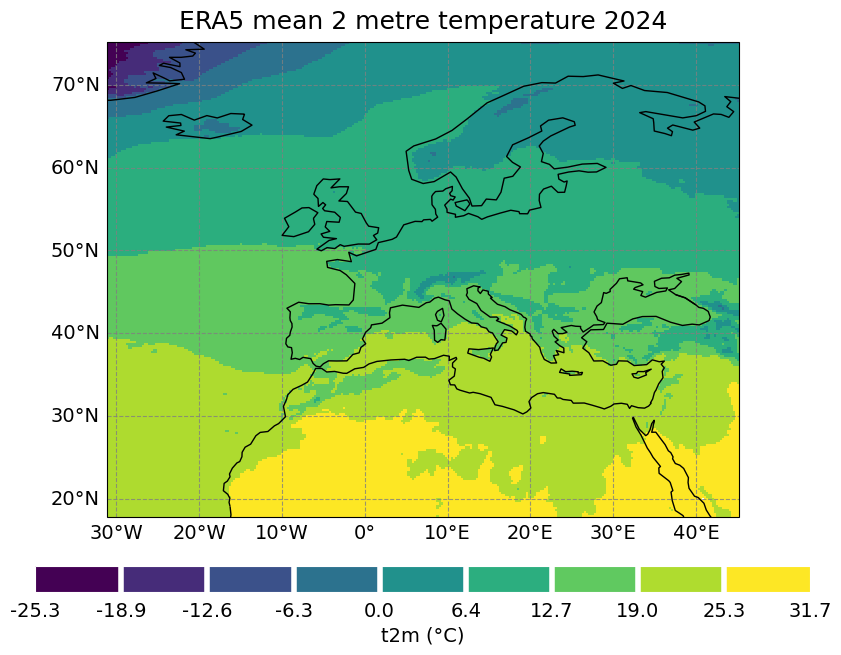

In [9]:
# Part 1: map at fixed time (mean over year)

# create a three dimensional DataArray
data_plt = ds[var]

# mean over time + °C conversion
data_plt = (ds[var].mean("time") - 273.15).compute()

# call plotting function
netcdf_map(
    data_plt,  # data to be mapped
    var,  # internal variable
    save_path,  # where to save
    "ERA5 mean 2 metre temperature 2024",  # title of the figure
    "map.png",  # fig file name
    10,  # number of colorbar levels
    f"{var} (°C)",  # color bar label
)

## Compute hourly temperature time series at grid point nearest to the input location

You are now asked to provide the spatial coordinates (latitude, longitude) of a location of your choince, within the availabe spatial domain. The ```while True``` block will check if your input is meaningful: it has to be a decimal number, with a dot separating integers from decimals and both latitude and longitude need to be inside the spatial bounds.

In [10]:
# Part 2: time evolution for one (lat,lon) point. Select nearest grid point to the input one

print(
    "Select a grid point inside the considered domain: "
    f"latitude {lat_min} to {lat_max}, longitude {lon_min} to {lon_max}: "
)
print(" e.g. Padova (lat, lon) = (45.40797,11.88586)")

while True:
    try:
        lat = float(input("Latitude  : "))
        lon = float(input("Longitude : "))
    except ValueError:  # non-numeric input
        print("Please enter numbers (use a dot as decimal separator).")
        continue

    # range checks
    if not (lat_min <= lat <= lat_max):
        print(
            "Invalid latitude selection. Please pick a "
            f"latitude value between {lat_min} and {lat_max}"
        )
        continue
    if not (lon_min <= lon <= lon_max):
        print(
            "Invalid longitude selection. Please pick a "
            f"longitude value between {lon_min} and {lon_max}"
        )
        continue

    break  # valid input, breaks the while True loop

print(f"Selected point: lat={lat}, lon={lon}")

Select a grid point inside the considered domain: latitude 18.0 to 75.0, longitude -31.0 to 45.0:
 e.g. Padova (lat, lon) = (45.40797,11.88586)
Selected point: lat=45.4, lon=11.88


The nearest grid point to the user's input is selected by the ```ds.sel()``` method, with ```method = "nearest"```. This gives back a Dataset with fixed spatial coordinates. Then we create a DataArray containing the ```t2m``` values and convert to Celsius. Then, we call the ```plot_dataarray_ds``` function to generate the hourly time series of temperatures in the selected grid point. The plot is shown here and saved in the selected folder.

Coordinates of the nearest grid point to the selected one: latitude = 45.5, longitude = 12.0


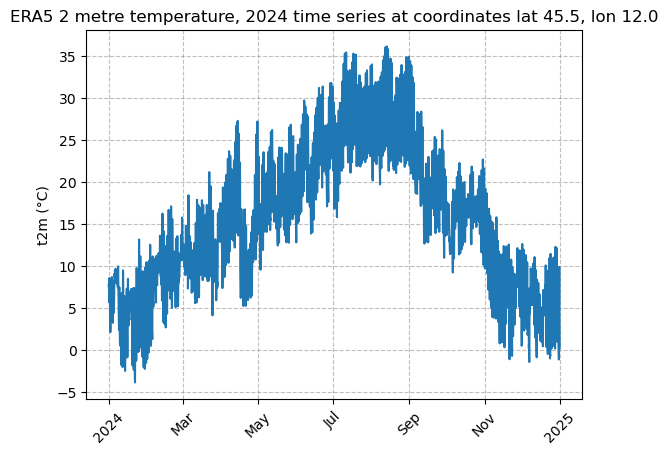

In [11]:
# select nearest point
ds_grid_point = ds.sel(latitude=lat, longitude=lon, method="nearest")
lat_nearest = ds_grid_point.latitude.values
lon_nearest = ds_grid_point.longitude.values
print(
    "Coordinates of the nearest grid point to the selected one: "
    f"latitude = {lat_nearest}, longitude = {lon_nearest}"
)

# create a multidimensional DataArray, convert to °C
da_point = ds_grid_point[var] - 273.15

plot_datarray_ts(
    [da_point],
    [da_point["time"]],
    ["-"],
    ["t2m"],
    "ERA5 2 metre temperature, 2024 time series at coordinates "
    f"lat {lat_nearest}, lon {lon_nearest}",
    f"{var} (°C)",
    f"hourly_t2m_time_series_lat_{lat}_lon_{lon}.png",
    save_path,
)

## Empirical CDF of hourly temperature in year 2024

We now compute the empirical cumulative distribution function (ECDF) and the relative 0.25, 0.50 and 0.75 quantiles of the hourly temperature data at the selected grid point.

First we store temperature data in ```t2m_vals```, a NumPy array using ```da_point.values```. To ensure that the array is one-dimensional, we immediately employ the ```.flatten()``` method. After that, the temperature data inside ```t2m_vals``` is sorted in ascending order and assigned to the variable ```x```, which again is a NumPy array. The expression ```np.arange(1, len(x) + 1)``` generates an array of integers from 1 to the total number of data points, and dividing this by the total number of data points gives the cumulative probabilities, which are stored in the variable y. After that, we plot the ECDF and save it in the selected folder.

The chosen quantiles are then calculated using the NumPy function ```np.quantile()```: their values are shown below the ECDF plot.

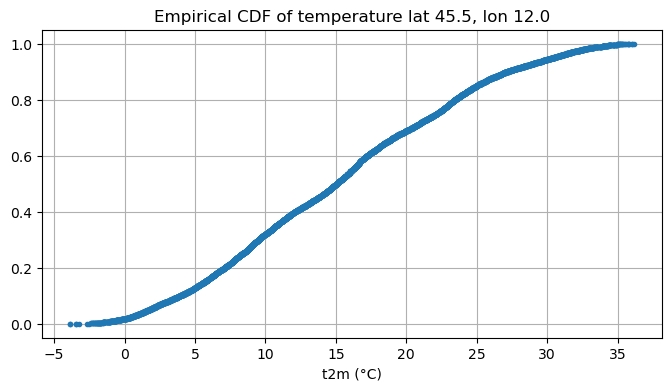

0.25 quantile: 8.4 °C
0.5 quantile: 15.1 °C
0.75 quantile: 22.2 °C


In [12]:
# create a 1D numpy array with temperature values
t2m_vals = da_point.values.flatten()
# sort the data
x = np.sort(t2m_vals)

# Compute ECDF values
y = np.arange(1, len(x) + 1) / len(x)

# Plot ECDF
plt.figure(figsize=(8, 4))
figname = "t2m_ecdf.png"
plt.plot(x, y, marker=".", linestyle="none")
plt.xlabel("t2m (°C)")
plt.title(f"Empirical CDF of temperature lat {lat_nearest}, lon {lon_nearest}")
plt.grid(True)
full_path = os.path.join(save_path, figname)
plt.savefig(full_path, bbox_inches="tight")
plt.show()
plt.close()


# Print quantiles
quantiles = [0.25, 0.50, 0.75]
q_val = np.quantile(t2m_vals, quantiles)

for n, q in zip(quantiles, q_val):
    print(f"{n} quantile: {q: .1f} °C")

## Compute daily and monthly averaged temperature time series at grid point nearest to the input location

Finally, we compute a temporal aggregation (daily and a monthly) of the ```da_point``` DataArray by using ```da_point.resample(time = "D")``` and ```da_point.resample(time = "MS")```;  then we compute the mean temperature over each day and month with the ```.mean()``` method. After that, the ```plot_dataarray_ds``` function is called once again to generate the new plot.
The annual mean temperature at the selected location is printed below the plot.

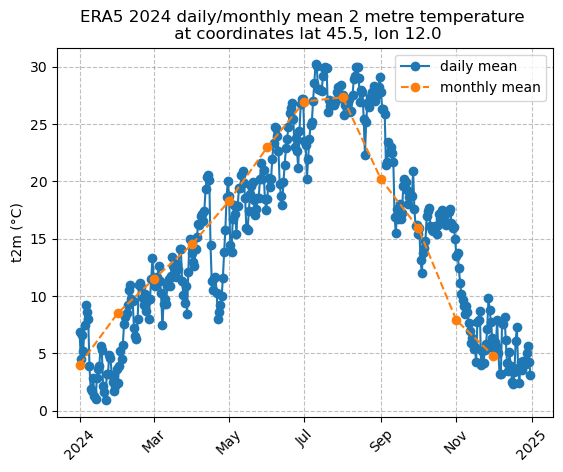

Annual mean:  15.269366826024884


In [13]:
# Part 3: daily and monthly mean temperature time evolution for the selected (lat,lon) point
da_day_mean_t2m = da_point.resample(time="D").mean()
da_month_mean_t2m = da_point.resample(time="MS").mean()

plot_datarray_ts(
    [da_day_mean_t2m, da_month_mean_t2m],
    [da_day_mean_t2m["time"], da_month_mean_t2m["time"]],
    ["-", "--"],
    ["daily mean", "monthly mean"],
    "ERA5 2024 daily/monthly mean 2 metre temperature \n "
    f"at coordinates lat {lat_nearest}, lon {lon_nearest}",
    f"{var} (°C)",
    f"daily_monthly_mean_t2m_time_series_lat_{lat}_lon_{lon}.png",
    save_path,
    markers=True,
    legend=True,
)
print("Annual mean: ", float(da_point.mean()))

## Take home messages 📌

In this notebook we explored how to work with climate data stored in a NetCDF file and learned to:

- Open the dataset with xarray and inspect its variables, dimensions, and metadata.
- Visualise the data with Matplotlib, producing a map and two line plots that show the temporal evolution at selected points.

We also have employed the lazy loading feature of xarray by opening the Dataset with ```chunks={"time": 744}```, keeping RAM usage low. Finally, we have organized parts of our code in functions for the sake of clarity and reusability.